一.现代CNN的奠基者：LeNet5

首先，图像从左侧输入，从右侧输出，数据传输方向与DNN一致。整个网络由2个卷积层、2个平均池化
层和2个全连接层组成，虽然没有标注出来，但每个卷积层和全连接层后都使用激活函数tanh或
sigmoid。

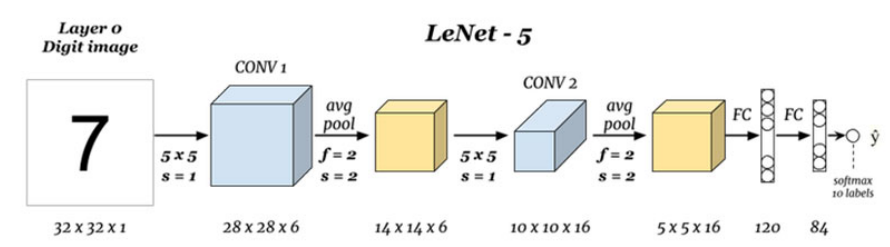

输入→(卷积+池化)→(卷积+池化)→(线性x2)→输出

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
data=torch.ones(size=(10,1,32,32))

class Model(nn.Module):
    def __init__(self):
        super().__init__() #super语法:super(当前类名, self).父类方法名(参数)
        self.conv1=nn.Conv2d(1,6,5)
        self.pool1=nn.AvgPool2d(2)
        self.conv2=nn.Conv2d(6,16,5)
        self.pool2=nn.AvgPool2d(2)
        self.fc1=nn.Linear(5*5*16,120)
        self.fc2=nn.Linear(120,84)
    def forward(self,x):
        x = F.tanh(self.conv1(x))
        x = self.pool1(x)
        x = F.tanh(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,5*5*16) #-1，我不关心-1这个位置上的数是多少，你根据我输入的x的结构帮我自己计算吧
    #卷积层的输出是 4D 张量：(batch_size, channels, height, width)
    #全连接层需要 2D 输入：(batch_size, features)
        x = F.tanh(self.fc1(x))
        output = F.softmax(self.fc2(x),dim=1) #(samples, features)#对每个样本的各个类别进行概率归一化
net=Model()
result=net(data)



In [3]:
from torchinfo import summary
net=Model()
summary(net,input_size=(10,1,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Conv2d: 1-1                            [10, 6, 28, 28]           156
├─AvgPool2d: 1-2                         [10, 6, 14, 14]           --
├─Conv2d: 1-3                            [10, 16, 10, 10]          2,416
├─AvgPool2d: 1-4                         [10, 16, 5, 5]            --
├─Linear: 1-5                            [10, 120]                 48,120
├─Linear: 1-6                            [10, 84]                  10,164
Total params: 60,856
Trainable params: 60,856
Non-trainable params: 0
Total mult-adds (M): 4.22
Input size (MB): 0.04
Forward/backward pass size (MB): 0.52
Params size (MB): 0.24
Estimated Total Size (MB): 0.81

二.从浅层到深度：AlexNet

AlexNet总共有11层，其中有5个卷积层、3个池化层、2个全连接隐藏层，1个全连接输出层，实际上，
在全连接层的前后AlexNet使用了Dropout层，但在大部分架构上都不会把DP表现出来。

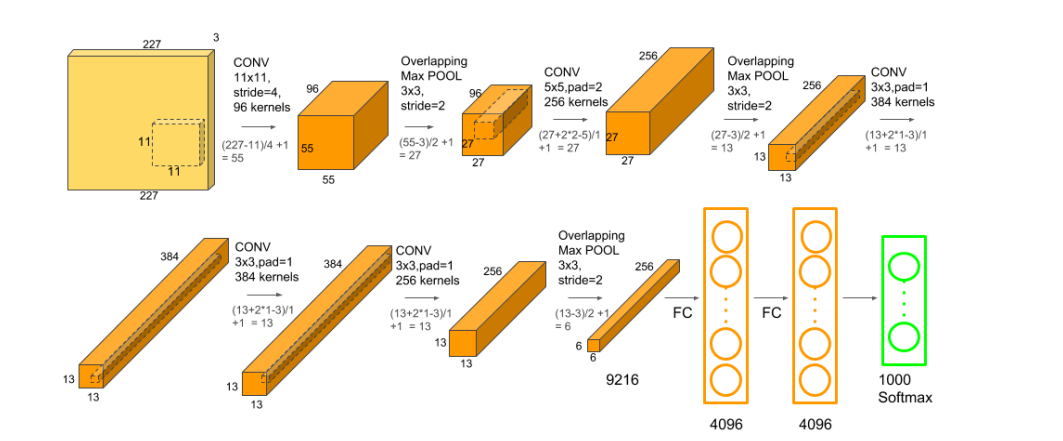

输入→(卷积+池化)→(卷积+池化)→(卷积x3+池化)→(线性x3)→输出

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

in_channels（必选）：输入张量的通道数。

out_channels（必选）：卷积操作后输出的通道数（即卷积核的数量）。

kernel_size（必选）：
卷积核的大小。


In [5]:
data=torch.ones(size=(10,3,227,227))
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        #为了处理尺寸较大的原始图片，先使用11x11的卷积核和较大的步长来快速降低特征图的尺寸
        #同时，使用比较多的通道数，来弥补降低尺寸造成的数据损失
        self.conv1 = nn.Conv2d(3,96, kernel_size=11, stride=4)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2) #overlap pooling
        
        #已经将特征图尺寸缩小到27x27，计算量可控，可以开始进行特征提取了
        #卷积核、步长恢复到业界常用的大小，进一步扩大通道来提取数据
        self.conv2 = nn.Conv2d(96,256,kernel_size=5,padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        #疯狂提取特征，连续用多个卷积层
        #kernel 5, padding 2, kernel 3, padding 1 可以维持住特征图的大小
        self.conv3 = nn.Conv2d(256,384,kernel_size=3, padding =1) 
        self.conv4 = nn.Conv2d(384,384,kernel_size=3, padding =1)
        self.conv5 = nn.Conv2d(384,256,kernel_size=3, padding =1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        #进入全连接层，进行信息汇总
        self.fc1 = nn.Linear(6*6*256,4096) #上层所有特征图上的所有像素
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,1000)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool3(x)

        x = x.view(-1,6*6*256) #将数据拉平

        x = F.dropout(x,p=0.5)
        x = F.relu(F.dropout(self.fc1(x),p=0.5))
        x = F.relu(self.fc2(x))
        output = F.softmax(self.fc3(x),dim=1)
     
    


In [6]:
net=Model()
result=net(data)

In [7]:
from torchinfo import summary
summary(net,input_size=(10,3,227,227))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Conv2d: 1-1                            [10, 96, 55, 55]          34,944
├─MaxPool2d: 1-2                         [10, 96, 27, 27]          --
├─Conv2d: 1-3                            [10, 256, 27, 27]         614,656
├─MaxPool2d: 1-4                         [10, 256, 13, 13]         --
├─Conv2d: 1-5                            [10, 384, 13, 13]         885,120
├─Conv2d: 1-6                            [10, 384, 13, 13]         1,327,488
├─Conv2d: 1-7                            [10, 256, 13, 13]         884,992
├─MaxPool2d: 1-8                         [10, 256, 6, 6]           --
├─Linear: 1-9                            [10, 4096]                37,752,832
├─Linear: 1-10                           [10, 4096]                16,781,312
├─Linear: 1-11                           [10, 1000]                4,097,000
Total params: 62,378,344
Trainable p